# Analysis on the MC-Dropout model

This work explores the theoretical analysis of [Chapter 6 of Gal's PhD Thesis](https://t.co/YXw7UX7I9P?amp=1)

## Overview

* Practical considerations for getting good uncertainty
* Factors that affects predictive uncertainty characteristics
* 


## Bayesian Linear Regression example comparing BBB and MC-Dropout

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

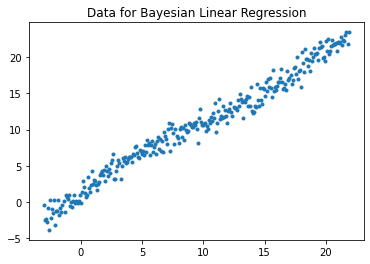

In [ ]:

def generate_data(n=100, sd=1, xlims=[-3,6*np.pi+3], seed=1,
                  f = lambda x: 1 + x + np.sin(x/3)*(x>0)*(x<6*np.pi)):
    '''
    This version more accurately reflects the functional relationship?
    `np.sin(x/3)*(x>0)*(x<6*np.pi))` is not intuitive feature engineering
    and without specifying this correctly the linear specification is wrong
    and subsequently the normality assumptions of the model are incorrect.

    Are you sure you want to introduce correlated errors into the analysis?
    '''

    np.random.seed(seed)
    x = np.linspace(*xlims, n)
    y = f(x) + np.random.normal(0, sd, n)
    return x,y

x, y = generate_data(300)
plt.plot(x, y, '.')
plt.title("Data for Bayesian Linear Regression")
plt.show()

### Derive the posterior

Assume Prior $\mathbf{w} \sim N(0, \mathbf{I})$ \\
Likelihood $p(Y|X, \mathbf{w}) = \overbrace{N(\boldsymbol{\psi}(X)\mathbf{w}, \mathbf{I})}^{\text{ah $\boldsymbol{\psi}$ -- now I see!}}$ 

\begin{align*}
\log p(\mathbf{w}| D) &= \log p(\mathbf{w}) + \log p(Y|X,\mathbf{w}) + C \\
&= -\frac{1}{2}||\mathbf{w}||^2 - \frac{1}{2}||\boldsymbol{\psi}(X)\mathbf{w} - Y||^2 + C \\
&= -\frac{1}{2} (\mathbf{w}-\mu)^TΣ^{-1}(\mathbf{w}-\mu) + C
\end{align*},

where $\Sigma^{-1} = \boldsymbol{\psi}(X)^T \boldsymbol{\psi}(X) + I$ and $\mu = (\boldsymbol{\psi}(X)^T \boldsymbol{\psi}(X) + I)^{-1}\boldsymbol{\psi}(X)^TY$

Thus the posterior of $\mathbf{w}$ is also Gaussian:
$$p(\mathbf{w}|D) = N(\mu, \Sigma)$$

In [ ]:
x, y = generate_data(1000)

# 1. Consider non-linearity

# so since f = lambda x: 1 + x + np.sin(x/3)*(x>0)*(x<6*np.pi)
nonlinear_f = lambda x: np.sin(x/3)*(x>0)*(x<6*np.pi)
psiX = np.concatenate([1+0*x[:,np.newaxis], 
                      x[:,np.newaxis], nonlinear_f(x[:,np.newaxis])],axis=1)

def analytical_post(psiX):
  post_COV = np.linalg.inv(psiX.T.dot(psiX)+np.eye(psiX.shape[1]))
  post_MU = post_COV.dot(psiX.T.dot(y))
  post_STD = np.diag(post_COV)**0.5 # posterior standard deviations

  print("posterior mean: ", post_MU)
  print("posterior std: ", post_STD)
  return post_MU, post_STD

post1_mu, post1_std = analytical_post(psiX)

posterior mean:  [1.05248924 0.99843718 1.01624549]
posterior std:  [0.05769751 0.00512674 0.05977914]


Analytical estimate for non-linear model:

Bias: mean = 1.05, std = 0.058

Slope: mean = 1, std = 0.005

Non-linear term/noise: mean = 1.02, std = 0.06

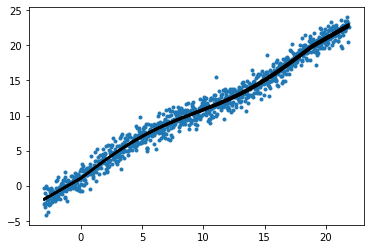

In [ ]:
plt.plot(x, y, '.')
for i in range(10):
  plt.plot(x, psiX.dot(np.random.normal(post1_mu, post1_std)), 'k')

In [ ]:
# 2. start from linear model

psiX = np.concatenate([1+0*x[:,np.newaxis], x[:,np.newaxis]],axis=1)
post2_mu, post2_std = analytical_post(psiX)

posterior mean:  [1.47362895 0.95370818]
posterior std:  [0.05210859 0.00440008]


Analytical estimate for linear model:

Bias: mean = 1.47, std = 0.05

Slope: mean = 0.95, std = 0.0044

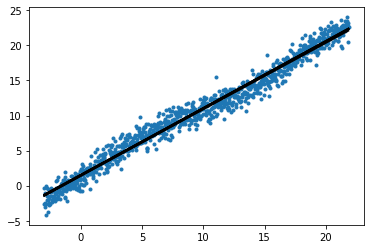

In [ ]:
plt.plot(x, y, '.')
for i in range(10):
  plt.plot(x, psiX.dot(np.random.normal(post2_mu, post2_std)), 'k')

In [ ]:
# MC sampling using PYMC3
import pymc3 as pm

def mc_sampling(linear=True):
  with pm.Model() as lr_model:
    
    # prior
    w = pm.Normal("slope", mu=0, sigma=1)
    b = pm.Normal("bias", mu=0, sigma=1)



    if not linear:
    # Likelihood with non-linearity
      likelihood = pm.Normal("y", mu = w*x + b + nonlinear_f(x), sigma=1, observed=y)
    else:
    # Linear model
      likelihood = pm.Normal("y", mu = w*x + b, sigma=1, observed=y)

    # posterior
    posterior = pm.sample(1000, cores=3, return_inferencedata=False)
    return posterior

def analyze_sampling(trace, analytical_mu):
  fig, ax = plt.subplots(1, 2, figsize=(14,5))
  w_samples = trace.get_values("slope")
  w_mean = w_samples.mean()
  w_std = w_samples.std()
  ax[0].hist(w_samples, bins=50)
  ax[0].axvline(w_mean, color="black", label="posterior mean")
  ax[0].axvline(analytical_mu[1], color="r", label="analytical mean")
  ax[0].axvline(w_mean - 2*w_std, color="r", linestyle='dotted')
  ax[0].axvline(w_mean + 2*w_std, color="r", linestyle='dotted')

  b_samples = trace.get_values("bias")
  b_mean = b_samples.mean()
  b_std = b_samples.std()
  ax[1].hist(b_samples, bins=50)
  ax[1].axvline(b_mean, color="black", label="posterior mean")
  ax[1].axvline(analytical_mu[0], color="r", label="analytical mean")
  ax[1].axvline(b_mean - 2*b_std, color="r", linestyle='dotted')
  ax[1].axvline(b_mean + 2*b_std, color="r", linestyle='dotted')

  ax[0].legend()
  ax[1].legend()
  plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [bias, slope]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 11 seconds.
The acceptance probability does not match the target. It is 0.8809231183914121, but should be close to 0.8. Try to increase the number of tuning steps.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  after removing the cwd from sys.path.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood

<Figure size 504x504 with 0 Axes>

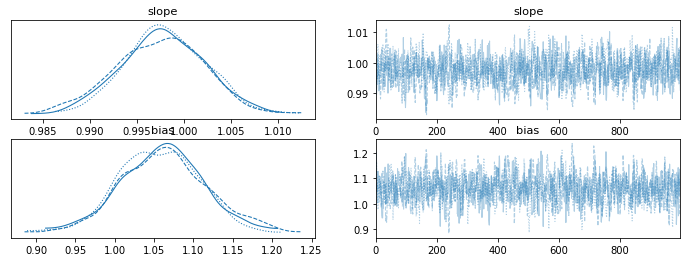

In [ ]:
# 1. non-linear model
posterior1 = mc_sampling(linear=False)
plt.figure(figsize=(7,7))
pm.traceplot(posterior1)
plt.show()

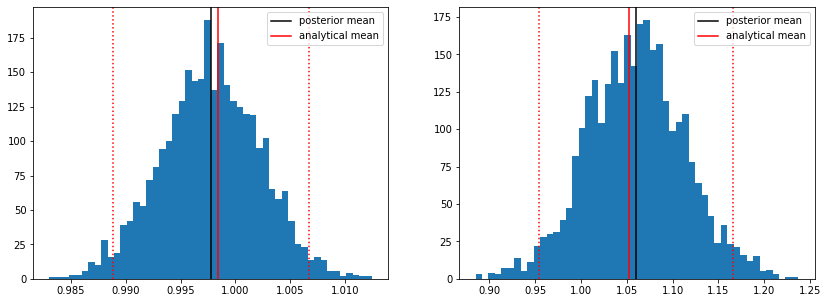

In [ ]:
analyze_sampling(posterior1, post1_mu)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [bias, slope]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 11 seconds.
The acceptance probability does not match the target. It is 0.8843714481903672, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  after removing the cwd from sys.path.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWa

<Figure size 504x504 with 0 Axes>

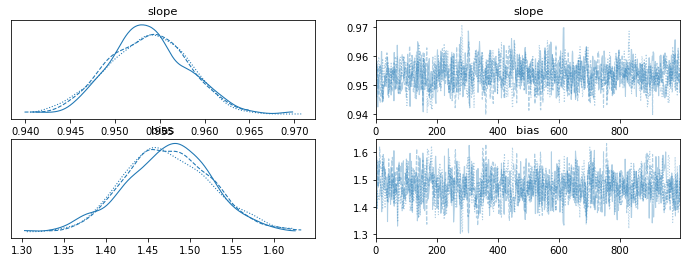

In [ ]:
# 2. linear model
posterior2 = mc_sampling(linear=True)
plt.figure(figsize=(7,7))
pm.traceplot(posterior2)
plt.show()

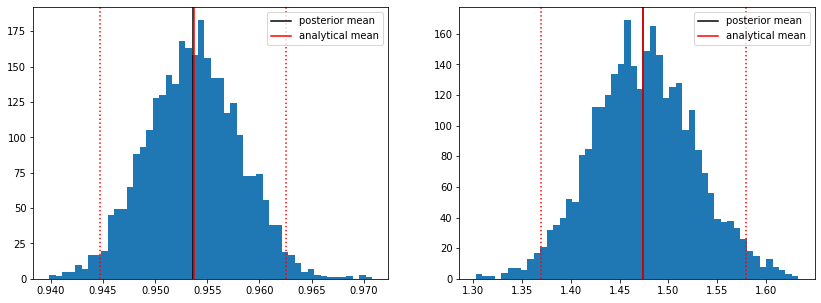

In [ ]:
analyze_sampling(posterior2, post2_mu)

In [ ]:
# https://www.tensorflow.org/guide/keras/custom_callback
# https://stackoverflow.com/questions/48488549/keras-append-to-logs-from-callback
from tensorflow import keras
class CustomErrorMonitor(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    #https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DenseReparameterization
    logs['kernel_kl'] = kl_div(self.model.layers[1].kernel_posterior, self.model.layers[1].kernel_prior, _).numpy()
    logs['bias_kl'] = kl_div(self.model.layers[1].bias_posterior, self.model.layers[1].bias_prior, _).numpy()
    #logs['neg_loglik'] = neg_loglik(y[:,np.newaxis], model_BBB(x)).numpy().mean()
    logs['neg_loglik'] = np.mean([neg_loglik(y[(b*32):((b+1)*32),np.newaxis], model_BBB(x[(b*32):((b+1)*32)])).numpy().mean() for b in range(int(len(x)/batch_size))])
    logs['bias'] = model_BBB.layers[1].bias_posterior.mean().numpy()[0]
    logs['bias_sd'] = model_BBB.layers[1].bias_posterior.stddev().numpy()[0]
    logs['kernel'] = model_BBB.layers[1].kernel_posterior.mean().numpy()[0][0]
    logs['kernel_sd'] = model_BBB.layers[1].kernel_posterior.stddev().numpy()[0][0]

In [ ]:
# BBB approximation using full-rank Gaussian # i.e., standard multivariate normal

def neg_loglik(target, pred_distribution):
  return -pred_distribution.log_prob(target)

# KL-term corrected with *kl / num_examples_per_epoch* adjustment,
# which is independent from batch_size, as it is already averaged by batch_size 
# in forward pass once per minibatch
def kl_div(q, p, _):
  return tfpd.kl_divergence(q, p)/x.shape[0]

tfpl = tfp.layers
tfpd = tfp.distributions

import tensorflow.compat.v1 as tf1

def create_BBB_model(linear):
  inputs = layers.Input(shape=(1,))
  BBB = tfpl.DenseReparameterization


  if not linear:
    # x -> [x, non-linear term]
    features = BBB(20, activation="relu", kernel_divergence_fn=kl_div,
                  bias_divergence_fn=kl_div, # this doesn't do anything
                  bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=True,
                      loc_initializer=tf1.initializers.random_normal(mean=10, stddev=3)),
                  kernel_posterior_fn = tfpl.default_mean_field_normal_fn(
                      loc_initializer=tf1.initializers.random_normal(mean=1, stddev=0.1),
                      untransformed_scale_initializer=tf1.initializers.random_normal(mean=10, stddev=0.1))
                  )(inputs)
    features = BBB(1, activation="relu", kernel_divergence_fn=kl_div,
                  bias_divergence_fn=kl_div,
                  bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=True,
                    loc_initializer=tf1.initializers.random_normal(mean=-10, stddev=5)),
                  kernel_posterior_fn = tfpl.default_mean_field_normal_fn(
                    loc_initializer=tf1.initializers.random_normal(mean=100, stddev=1),
                    untransformed_scale_initializer=tf1.initializers.random_normal(mean=100, stddev=0.1))
                )(features)
    features = layers.Concatenate(axis=1)([inputs,features])
  else:
    # features = inputs
    pass

  lm = BBB(1, activation=None,
          kernel_divergence_fn=kl_div,
          bias_divergence_fn=kl_div,
          # https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DenseReparameterization
          # bias_prior_fn: None (no prior, no variational inference) 
          # bias_posterior_fn: default_mean_field_normal_fn(is_singular=True) (which creates an instance of tfd.Deterministic)      
          # https://www.tensorflow.org/probability/api_docs/python/tfp/layers/default_mean_field_normal_fn 
          bias_posterior_fn = tfpl.default_mean_field_normal_fn(
                    loc_initializer=tf1.initializers.random_normal(mean=1.5, stddev=1),
                    untransformed_scale_initializer=tf1.initializers.random_normal(mean=10, stddev=0.01)),
          bias_prior_fn = tfpl.default_multivariate_normal_fn,
          # kernel_prior_fn: tfp.layers.default_multivariate_normal_fn
          # kernel_posterior_fn: tfp_layers_util.default_mean_field_normal_fn()    
          kernel_posterior_fn = tfpl.default_mean_field_normal_fn(
                    loc_initializer=tf1.initializers.random_normal(mean=1, stddev=1),
                    untransformed_scale_initializer=tf1.initializers.random_normal(mean=-3, stddev=0.01))
          )(inputs)

  features = BBB(0, activation="relu", kernel_divergence_fn=kl_div,
               bias_divergence_fn=kl_div, # this doesn't do anything
               bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=True,
                   loc_initializer=tf1.initializers.random_normal(mean=10, stddev=3)),
               kernel_posterior_fn = tfpl.default_mean_field_normal_fn(
                   loc_initializer=tf1.initializers.random_normal(mean=1, stddev=.1),
                   untransformed_scale_initializer=tf1.initializers.random_normal(mean=10, stddev=0.1))
               )(inputs)
  features = layers.Concatenate(axis=1)([lm,features])
  params = features

  pred_distribution = tfpl.DistributionLambda(lambda params: 
                      tfpd.Normal(loc = params[:,0:1], 
                                  scale = 1))(params)#1e-3+tf.math.softplus(0.05*params[:,1:2])))(params)
  model_BBB = tf.keras.Model(inputs=inputs, outputs=pred_distribution)
  return model_BBB

model_BBB = create_BBB_model(linear=True)
model_BBB.compile(tf.keras.optimizers.Adam(), loss=neg_loglik) 
batch_size=32
tmp = model_BBB.fit(x, y, epochs=1000, verbose=0, #[:,np.newaxis]
                    batch_size=batch_size, callbacks=[CustomErrorMonitor(), 
                                                      keras.callbacks.CSVLogger('training.log')])

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


dict_keys(['loss', 'kernel_kl', 'bias_kl', 'neg_loglik', 'bias', 'bias_sd', 'kernel', 'kernel_sd'])

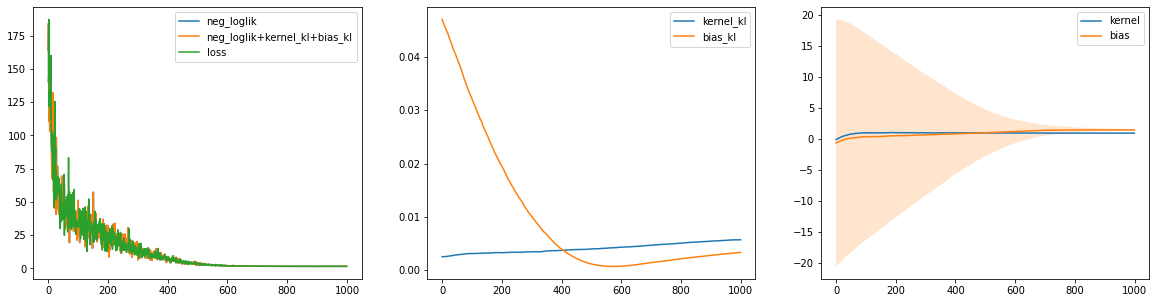

In [ ]:
fig,ax = plt.subplots(1,3, figsize=(20,5))
ax[0].plot(tmp.history['neg_loglik'], label='neg_loglik')
ax[0].plot(np.array(tmp.history['neg_loglik'])+
         np.array(tmp.history['kernel_kl'])+
         np.array(tmp.history['bias_kl']), label='neg_loglik+kernel_kl+bias_kl')
ax[0].plot(tmp.history['loss'], label='loss')
ax[0].legend()

ax[1].plot(np.array(tmp.history['kernel_kl']), label='kernel_kl')
ax[1].plot(np.array(tmp.history['bias_kl']), label='bias_kl')
ax[1].legend()

ax[2].fill_between(np.arange(0,len(tmp.history['kernel'])),
                   np.array(tmp.history['kernel'])-2*np.array(tmp.history['kernel_sd']), 
                   np.array(tmp.history['kernel'])+2*np.array(tmp.history['kernel_sd']), alpha=0.2)
ax[2].plot(tmp.history['kernel'], label='kernel')
ax[2].plot(tmp.history['bias'], label='bias')
ax[2].fill_between(np.arange(0,len(tmp.history['bias'])),
                   np.array(tmp.history['bias'])-2*np.array(tmp.history['bias_sd']), 
                   np.array(tmp.history['bias'])+2*np.array(tmp.history['bias_sd']), alpha=0.2)
ax[2].legend()
# ! head training.log
tmp.history.keys()

In [ ]:
(tmp.history['bias'][-1]),tmp.history['kernel'][-1],tmp.history['bias_sd'][-1],tmp.history['kernel_sd'][-1]

(1.5167882, 0.96858054, 1.9389838, 0.01712603)

In [ ]:
post2_mu, post2_std # posterior standard deviations

(array([1.47362895, 0.95370818]), array([0.05210859, 0.00440008]))

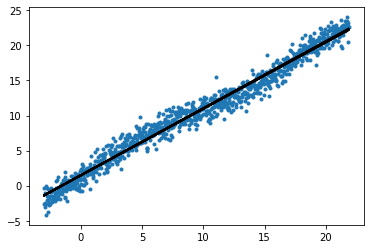

In [ ]:
#plt.plot(x, model_BBB.predict(x),'r')
plt.plot(x, y, '.')
for i in range(20):
  plt.plot(x, model_BBB(x).mean(),'k')

In [ ]:
model_BBB = create_BBB_model(linear=False)
model_BBB.compile(tf.keras.optimizers.Adam(), loss=neg_loglik) 
batch_size=32
tmp = model_BBB.fit(x, y, epochs=1000, verbose=0, #[:,np.newaxis]
                    batch_size=batch_size, callbacks=[CustomErrorMonitor(), 
                                                      keras.callbacks.CSVLogger('training.log')])

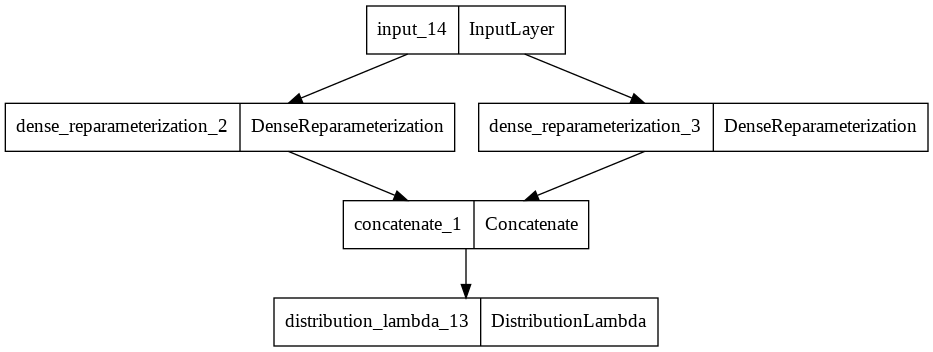

In [ ]:
keras.utils.plot_model(model_BBB)

In [ ]:
model_BBB.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 dense_reparameterization_2 (De  (None, 1)           4           ['input_14[0][0]']               
 nseReparameterization)                                                                           
                                                                                                  
 dense_reparameterization_3 (De  (None, 0)           0           ['input_14[0][0]']               
 nseReparameterization)                                                                           
                                                                                           

Text(0.5, 1.0, 'Prediction of VI model')

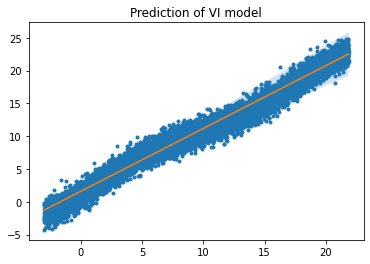

In [ ]:
# test for BBB
x_test = x # np.arange(-10, 30, 0.3)
predictions = []
for i in range(50):
  #predictions.append(model_BBB.predict(x_test)) # this samples pred_dist since
  # because default is convert_to_tensor_fn=tfp.distributions.Distribution.sample
  # https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DistributionLambda 
  # so if we're interested in characterizing uncertainty of the mean then we want
  predictions.append(model_BBB(x_test).mean())

predictions = np.array(predictions)
mu = np.squeeze(np.mean(predictions, axis=0))
std = np.squeeze(np.std(predictions, axis=0))

plt.plot(x, y, '.')
plt.plot(x_test, mu, label="Mean prediction")
plt.fill_between(x_test, mu - 2*std, mu + 2 * std, alpha=0.2)
plt.title("Prediction of VI model")

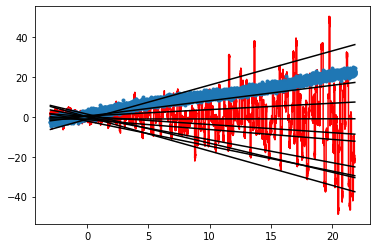

In [ ]:
plt.plot(x, model_BBB.predict(x),'r')
plt.plot(x, y, '.')
for i in range(10):
  plt.plot(x, model_BBB(x).mean(),'k')

## Dropout 

Based on Gal's analysis, optimal weight for the MC-Dropout model is:

$$w^* = ((1-p)NΣ + pNΛ + I)^{-1} X^TY$$

where $Σ = X^TX/N$ and $Λ = diag(X^TX)/N$, $p$ is the dropout rate (In Gal's analysis $1-p$ is the dropout rate)

In [ ]:
def dropout_analytical(psiX, p):
  a = (1-p) * psiX.T @ psiX + p * np.diag(np.diag(psiX.T @ psiX)) + np.eye(psiX.shape[1])
  optimal = np.linalg.inv(a) @ psiX.T @ y
  return optimal

psiX_nonlinear = np.concatenate([1+0*x[:,np.newaxis], 
                      x[:,np.newaxis], nonlinear_f(x[:,np.newaxis])],axis=1)
psiX = np.concatenate([1+0*x[:,np.newaxis], x[:,np.newaxis]],axis=1)

In [ ]:
dropout_analytical(psiX_nonlinear, p=0.1)

array([ 3.23587531,  0.85171228, -0.37147216])

In [ ]:
dropout_analytical(psiX, p=0.1)

array([3.14186911, 0.862806  ])

Note that when $p=0$ (no dropout), the optimal variational weight is equivalent to the MAP estimate $w = (X^TX+I)^{-1}X^TY$

In [ ]:
dropout_analytical(psiX_nonlinear, p=0)

array([1.05248924, 0.99843718, 1.01624549])

In [ ]:
dropout_analytical(psiX, p=0)

array([1.47362895, 0.95370818])

In [ ]:
# MC sampling using PYMC3 for MC-dropout model

def mc_sampling_dropout(p, linear=True):
  with pm.Model() as lr_model:

    if not linear:
      optimal = dropout_analytical(psiX_nonlinear, p)
      w = optimal[1] * pm.Bernoulli('slope', p=1-p)
      b = optimal[0] * pm.Bernoulli('bias', p=1-p)
      # Likelihood with non-linearity
      likelihood = pm.Normal("y", mu = w*x + b + nonlinear_f(x), sigma=1, observed=y)
    else:
      # Linear model
      optimal = dropout_analytical(psiX, p)
      w = optimal[1] * pm.Bernoulli('slope', p=1-p)
      b = optimal[0] * pm.Bernoulli('bias', p=1-p)
      likelihood = pm.Normal("y", mu = w*x + b, sigma=1, observed=y)

    # posterior
    posterior = pm.sample(1000, cores=3, return_inferencedata=False)
    return posterior
    
def analyze_sampling_dropout(trace, analytical_mu):
  fig, ax = plt.subplots(1, 2, figsize=(14,5))
  w_samples = trace.get_values("slope")
  w_mean = w_samples.mean() * analytical_mu[1]
  w_std = w_samples.std()
  ax[0].hist(w_samples, bins=50)
  ax[0].axvline(w_mean, color="black", label="posterior mean")
  ax[0].axvline(analytical_mu[1], color="r", label="analytical mean")
  ax[0].axvline(w_mean - 2*w_std, color="r", linestyle='dotted')
  ax[0].axvline(w_mean + 2*w_std, color="r", linestyle='dotted')

  b_samples = trace.get_values("bias")
  b_mean = b_samples.mean() * analytical_mu[0]
  b_std = b_samples.std()
  ax[1].hist(b_samples, bins=50)
  ax[1].axvline(b_mean, color="black", label="posterior mean")
  ax[1].axvline(analytical_mu[0], color="r", label="analytical mean")
  ax[1].axvline(b_mean - 2*b_std, color="r", linestyle='dotted')
  ax[1].axvline(b_mean + 2*b_std, color="r", linestyle='dotted')

  ax[0].legend()
  ax[1].legend()
  plt.show()

Multiprocess sampling (3 chains in 3 jobs)
BinaryGibbsMetropolis: [slope, bias]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 5 seconds.
/usr/local/lib/python3.7/dist-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  after removing the cwd from sys.path.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got

<Figure size 504x504 with 0 Axes>

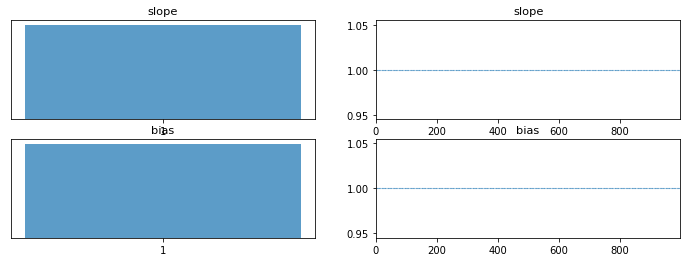

In [ ]:
# 2. linear model
posterior_do2 = mc_sampling_dropout(linear=True, p=0.1)
plt.figure(figsize=(7,7))
pm.traceplot(posterior_do2)
plt.show()

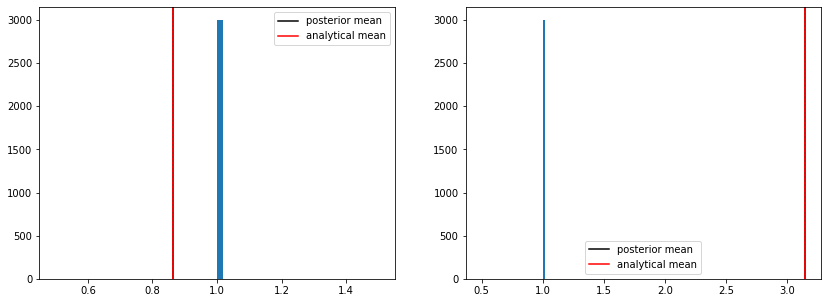

In [ ]:
analyze_sampling_dropout(posterior_do2, dropout_analytical(psiX, 0.1))

In [ ]:
# Scott adding his PyMC attemp as well! Feb 16
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt

In [ ]:
n = 100
x = np.random.normal(loc=10, size=n)

width,depth=10,1
d = np.zeros((width,depth)) # if we mask this it will be automatically imputed
d = np.ma.masked_array(d, mask = d==0) # via sampling it from its distribution
# WRONG THIS WILL BE SAMPLED FROM THE CONDITIONAL POSTERIOR DISTRIBUTION 
# of variable `d` conditional on all other values! 
# That's why it's posterior chains are "sticky"!!

with pm.Model() as dropout_network:
    dropout_rate = 0.5
    dropout_layers = pm.Bernoulli("dropout", p=dropout_rate, shape=d.shape, observed=d)
    mu = pm.Normal("prior", shape=d.shape)
    pm.Normal("likelihood", mu=mu.T.dot(dropout_layers), sigma=1, observed=x)
    step = pm.Slice()
    #pm.Metropolis([mu], tune=False)#, S=np.array([5]), proposal_dist=pm.UniformProposal)
    # I played around with some different proposals, as well as not setting this
    # which then defaults to a NUTS (an HMC) sampler

    # By observing the different behavior of the posterior chains for `d`
    # I came to understand that `d` was sampling from it's conditional posterior
    # not it's prior, and this is what helped me understand your comments!!

with dropout_network:
    trace = pm.sample(200, step=step, tune=200, chains=2)

/usr/local/lib/python3.7/dist-packages/pymc3/model.py:1755: ImputationWarning: Data in dropout contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Only 200 samples in chain.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Slice: [prior]
>Slice: [dropout_missing]


Sampling 2 chains for 200 tune and 200 draw iterations (400 + 400 draws total) took 7 seconds.
/usr/local/lib/python3.7/dist-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


In [ ]:
d # how does observed=d work in the dropout layer
# how is it different from sampling from the posterier without any evidence (observed masked values)

masked_array(
  data=[[--],
        [--],
        [--],
        [--],
        [--],
        [--],
        [--],
        [--],
        [--],
        [--]],
  mask=[[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True]],
  fill_value=1e+20,
  dtype=float64)

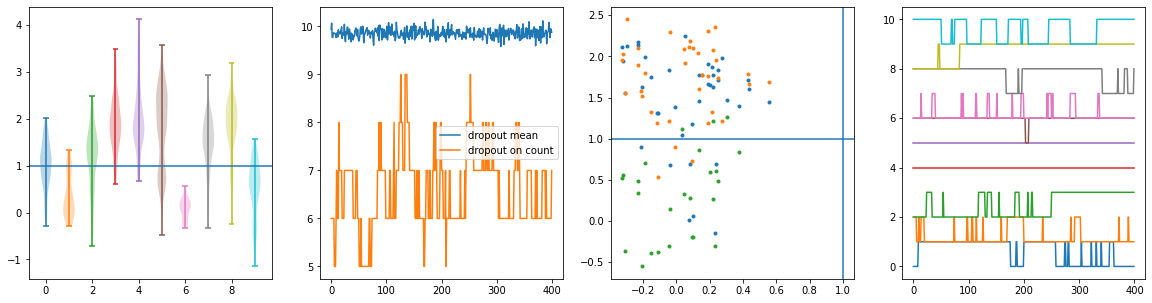

In [ ]:
fit,ax = plt.subplots(1,4, figsize=(20,5))
for i in range(width):
  ax[0].violinplot(trace.prior[trace.dropout_missing[:,i]==1,i,0], positions=[i])
ax[0].axhline(1)
ax[1].plot((trace.prior[:,:,0]*trace.dropout_missing).sum(axis=1),label='dropout mean')
ax[1].plot(trace.dropout_missing.sum(axis=1),label='dropout on count')
ax[1].legend()
for i in range(6,7):
  for j in range(7,10):
    kp = trace.dropout_missing[:,i]==1
    kp = kp & (trace.dropout_missing[:,j]==1)
    ax[2].plot(trace.prior[kp,i,0], trace.prior[kp,j,0],'.')
ax[2].axhline(1)
ax[2].axvline(1)
for i in range(10):
  ax[3].plot(trace.dropout_missing[:,i]+i)

In [ ]:
class CustomErrorMoniterDropout(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    #logs['neg_loglik'] = neg_loglik(y[:,np.newaxis], model_BBB(x)).numpy().mean()
    logs['neg_loglik'] = np.mean([neg_loglik(y[(b*32):((b+1)*32),np.newaxis], model_Dropout(x[(b*32):((b+1)*32)])).numpy().mean() for b in range(int(len(x)/batch_size))])
    logs['bias'] = model_Dropout.layers[1].bias.numpy()[0]
    # logs['bias_sd'] = model_BBB.layers[1].bias_posterior.stddev().numpy()[0]
    logs['kernel'] = model_Dropout.layers[1].kernel.numpy()[0][0]
    # logs['kernel_sd'] = model_BBB.layers[1].kernel_posterior.stddev().numpy()[0][0]

In [ ]:
# MC-Dropout

inputs = layers.Input(shape=(1,))
# features = layers.Dense(20)(inputs)
# features = layers.Dropout(0.1)(features, training=True)

params = layers.Dense(1)(inputs)
params = layers.Dropout(0.1)(params)

pred_distribution = tfp.layers.DistributionLambda(
    lambda params: tfp.distributions.Normal(loc=params[:,0:1], scale=1)
)(params)
model_Dropout = tf.keras.Model(inputs=inputs, outputs=pred_distribution)
model_Dropout.compile(tf.keras.optimizers.Adam(), loss=neg_loglik)
hist = model_Dropout.fit(x, y, epochs=500, verbose=0, batch_size=batch_size)

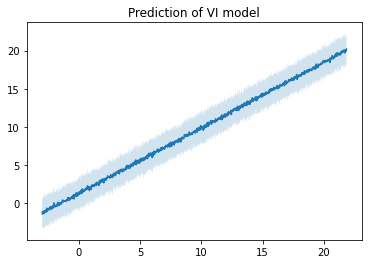

In [ ]:
# test for Dropout
x_test = x
predictions = []
for i in range(50):
  predictions.append(model_Dropout.predict(x_test))
predictions = np.array(predictions)
mu = np.squeeze(np.mean(predictions, axis=0))
std = np.squeeze(np.std(predictions, axis=0))

plt.plot(x_test, mu, label="Mean prediction")
plt.fill_between(x_test, mu - 2*std, mu + 2 * std, alpha=0.2)
plt.title("Prediction of VI model")
plt.show()

## What contributes to good uncertainty estimates
* A large number of parameters (model complexity) can result in better uncertainty estimates

* The dropout probability matters. Larger models requre larger dropout probabilities, since the weight of entropy is scaled by the model size $K$